# Creacion del modelo con LSTM

Despues de analizar diversos metodos para realizar predicciones sobre este activo tan particular, se decidio utilizar redes neuronales recurrentes.

Long Short-Term Memory son un tipo especial de redes neuronales recurrentes (RNN) diseñadas para modelar secuencias de datos donde el orden de los elementos es crucial.

In [313]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import plotly_express as px
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
import datetime
from lightgbm import LGBMRegressor
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.metrics import r2_score


In [314]:
conn = sql.connect('Data/db/btc.db')
cursor = conn.cursor()
df_1d = pd.read_sql_query("SELECT * FROM btc_1d", conn)

In [315]:
df_1d.tail(2)

,date,time,close,open,high,low,volume,var,return,diff,...,D,close_shifted,TR,ATR,TP,CCI,lag1_TR,lag2_TR,lag1_ATR,lag2_ATR
4973,2024-08-23 23:59:09,1724457600000,64157.01,64037.24,64494.50,63531.00,15857.15616,NaN,0.187032,119.77,...,85.008494,64037.24,963.50,2532.836429,64060.836667,136.666548,2312.21,1434.22,2437.815000,2572.219286
4974,2024-08-25 00:00:57,1724544000000,64169.99,64157.02,64507.04,63773.27,8909.11990,NaN,0.020216,12.97,...,90.609019,64157.01,733.77,2330.157857,64150.100000,132.352502,2600.00,2437.56,2496.201429,2553.417143


In [316]:
fecha = df_1d['date'][-1:].values[0]
ultima_fecha = pd.to_datetime(fecha)
# Número de días que quieres generar (ajusta este valor según tu necesidad)
num_dias = len(df_1d)

# Crear una lista de fechas decrementando un día en cada iteración
fechas = pd.date_range(end=ultima_fecha, periods=num_dias)

df_1d['date'] = fechas

In [317]:
df_1d.index = fechas

In [318]:
print(len(df_1d.index))
print(len(pd.date_range(
                    start = df_1d.index.min(),
                    end   = df_1d.index.max())))
                    #freq  = data_1d.index.freq)))
print(df_1d.index.min())
print(df_1d.index.max())

4975
4975
2011-01-12 00:00:57
2024-08-25 00:00:57


Corroborar que el indice sea unico y no tenga nulos.

In [319]:
print(df_1d.index.is_unique)
print(df_1d.index.hasnans)

True
False


Comprobaciones de consistencia de datos diarios: el código verifica si el índice del DataFrame df_1d contiene una secuencia diaria continua, garantizando que no haya fechas faltantes o espacios en los datos.

In [320]:
(df_1d.index == pd.date_range(
                    start = df_1d.index.min(),
                    end   = df_1d.index.max())).all()

True

# Pronosticador Autoregresivo o ForecasterAutoreg

In [321]:
#Forecaster
forecaster = ForecasterAutoreg(
    regressor= LGBMRegressor(max_depth=2,learning_rate=0.2,n_estimators=100,random_state=123),
    lags = [5,10,25,50,100,150,300]
)


In [322]:
forecaster.summary

<bound method ForecasterBase.summary of ================= 
ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.2, max_depth=2, random_state=123) 
Lags: [  5  10  25  50 100 150 300] 
Transformer for y: None 
Transformer for exog: None 
Window size: 300 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2024-08-29 19:41:20 
Last fit dat

In [323]:
df_1d.loc['2012-01-18 00:00:00':'2024-07-20 00:00:00'].shape

(4567, 34)

### Fechas de entrenamiento y validacion

In [357]:
data_1d = df_1d.loc['2012-01-18 00:00:00':'2024-07-20 00:00:00']
inicio_train = '2012-01-18 00:00:00'
fin_train = '2023-07-15 00:00:00'
fin_validacion = '2024-07-15 00:00:00'

In [325]:
datos_train = data_1d.loc[:fin_train,:] # 2 años y 3 meses
datos_val = data_1d.loc[fin_train:fin_validacion,:] # 2 meses (Diferencia entre el final de los datos de train y la validacion)
datos_test = data_1d.loc[fin_validacion:,:] # 1 meses (fin de validacion a final de los datos)

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 2012-01-18 00:00:57 --- 2023-07-14 00:00:57  (n=4196)
Fechas validacion : 2023-07-15 00:00:57 --- 2024-07-14 00:00:57  (n=366)
Fechas test : 2024-07-15 00:00:57 --- 2024-07-19 00:00:57  (n=5)


C:\Users\Pablo\AppData\Local\Temp\ipykernel_18236\1086612171.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



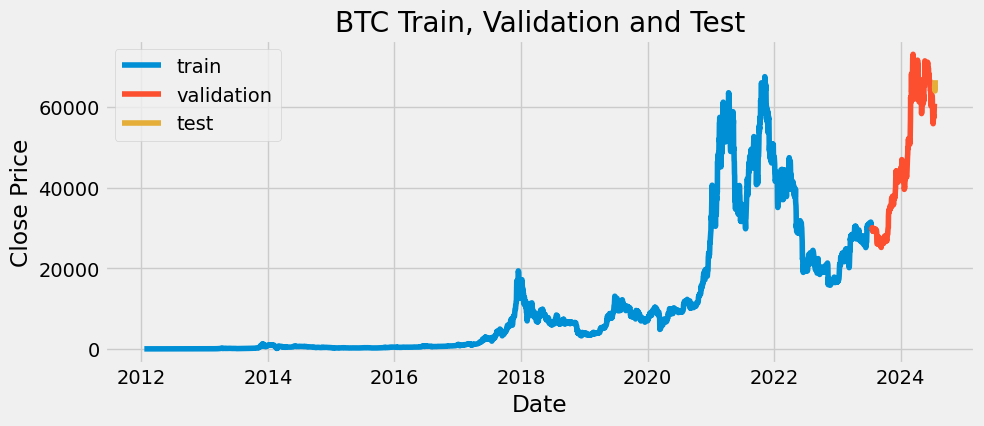

In [326]:
data_1d.loc[:fin_train,'partition'] = 'train'
data_1d.loc[fin_train:fin_validacion,'partition'] = 'validation'
data_1d.loc[fin_validacion:,'partition'] = 'test'

# Crear el gráfico
plt.figure(figsize=(10, 4))
for partition in ['train', 'validation', 'test']:
    subset = data_1d[data_1d['partition'] == partition]
    plt.plot(subset['date'], subset['close'], label=partition)

plt.title('BTC Train, Validation and Test')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [327]:
forecaster.fit(y=data_1d.loc[:fin_validacion,'close'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4262, number of used features: 7
[LightGBM] [Info] Start training from score 14390.713435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [328]:
predicciones = forecaster.predict(steps=5)
predicciones

2024-07-15 00:00:57    56195.194140
2024-07-16 00:00:57    55814.297748
2024-07-17 00:00:57    58024.776735
2024-07-18 00:00:57    57311.711398
2024-07-19 00:00:57    60660.011823
Freq: D, Name: pred, dtype: float64

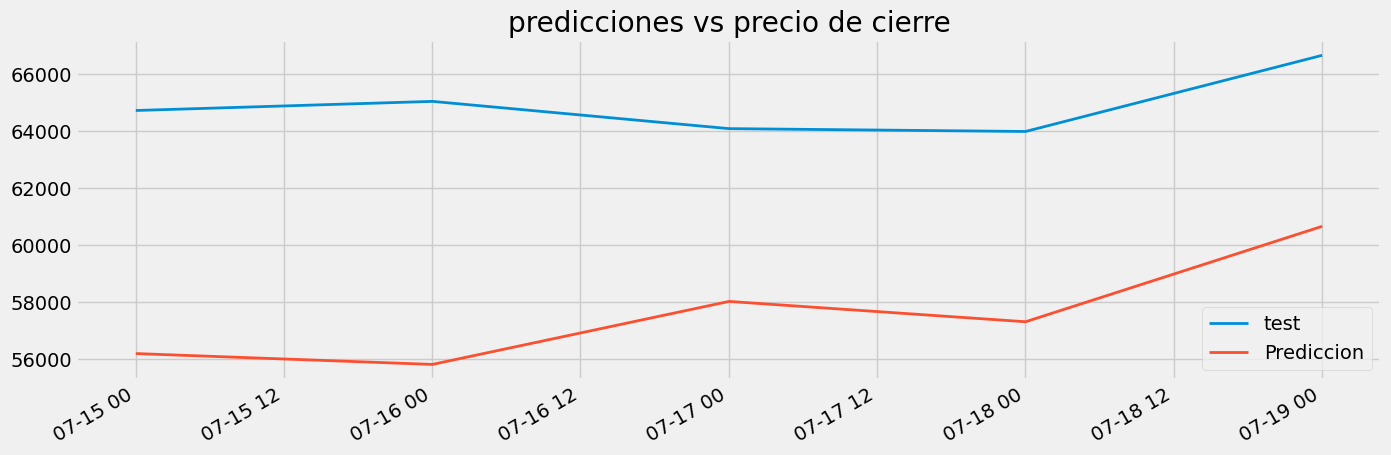

In [329]:
fig, ax = plt.subplots(figsize=(15,5))
data_1d.loc[predicciones.index,'close'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2, label='Prediccion',ax=ax)
ax.set_title('predicciones vs precio de cierre')
ax.legend()

In [330]:
# Error test
# ==============================================================================
r2 = r2_score(
                y_true = datos_test['close'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {r2}")

Error de test (mse): -58.317726530413566


# Optimizacion de hiperparametros


In [331]:
## Búsqueda de hiperparámetros: grid search
## ==============================================================================
#steps = 19
#forecaster = ForecasterAutoreg(
#                regressor = LGBMRegressor(random_state=123),
#                lags      = 12 # Este valor será remplazado en el grid search
#             )
#
## Valores candidatos de lags
#lags_grid = [[10,25,50,75,100],
#             [50,100,150,200],
#             [30,180,360],
#             [5,25,50]]
#
## Valores candidatos de hiperparámetros del regresor
#param_grid = {
#      'n_estimators': [100, 250,500],
#      'max_depth': [3, 5, 10],
#      'learning_rate': [0.1,0.01]
#}
#
#resultados_grid = grid_search_forecaster(
#                        forecaster         = forecaster,
#                        y                  = datos_train['close'],
#                        param_grid         = param_grid,
#                        lags_grid          = lags_grid,
#                        steps              = steps,
#                        refit              = False,
#                        metric             = 'mean_squared_error',
#                        initial_train_size = int(len(datos_train)*0.5),
#                        fixed_train_size   = False,
#                        return_best        = True,
#                        n_jobs             = 'auto',
#                        verbose            = False
#                  )

In [338]:
#Forecaster
forecaster = ForecasterAutoreg(
    regressor= LGBMRegressor(max_depth=5,learning_rate=0.1,n_estimators=500,random_state=123),
    lags = [1,50,100]
)

In [339]:
forecaster.fit(y=datos_train['close'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 3
[LightGBM] [Info] Start training from score 10782.801034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [340]:
steps=5
predicciones = forecaster.predict(steps=steps)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


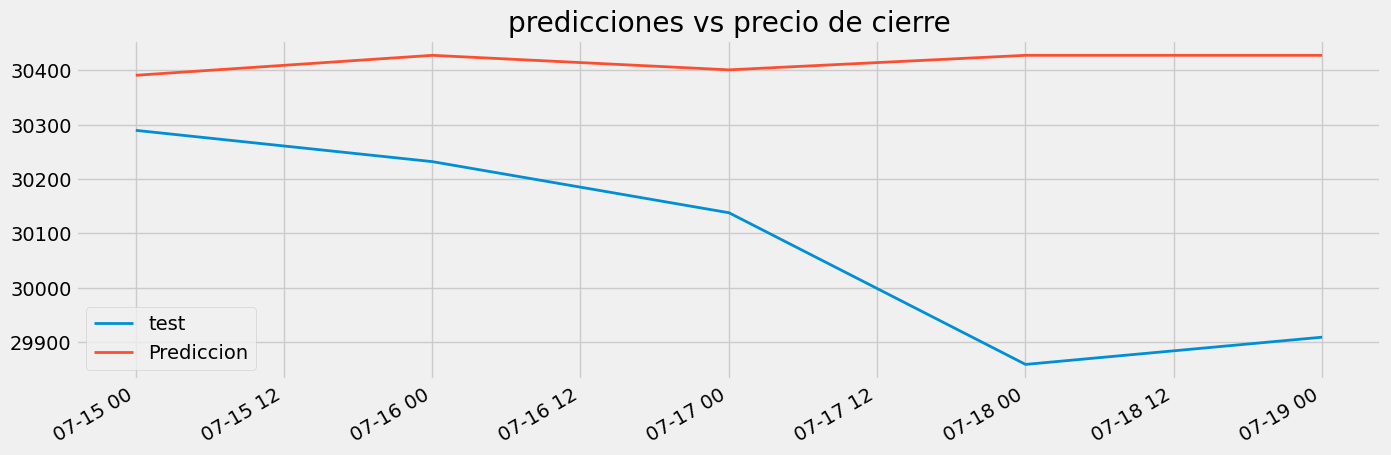

In [341]:
fig, ax = plt.subplots(figsize=(15,5))
data_1d.loc[predicciones.index,'close'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2, label='Prediccion',ax=ax)
ax.set_title('predicciones vs precio de cierre')
ax.legend()

In [342]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['close'],
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 1190202723.3697019


In [343]:
# Error test
# ==============================================================================
r2 = r2_score(
                y_true = datos_test['close'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {r2}")

Error de test (mse): -1281.405978962


# Variables exogenas

In [344]:
data_1d

,date,time,close,open,high,low,volume,var,return,diff,...,close_shifted,TR,ATR,TP,CCI,lag1_TR,lag2_TR,lag1_ATR,lag2_ATR,partition
2012-01-18 00:00:57,2012-01-18 00:00:57,1326844800000,5.90,5.60,6.90,5.10,226680.00000,5.71,5.357143,0.30,...,5.60,1.80,0.985714,5.966667,-8.053550,0.30,0.20,0.192857,0.485714,train
2012-01-19 00:00:57,2012-01-19 00:00:57,1326931200000,6.40,5.90,6.40,5.90,114820.00000,7.43,8.474576,0.50,...,5.90,0.50,0.907143,6.233333,5.719207,0.10,0.40,0.192857,0.442857,train
2012-01-20 00:00:57,2012-01-20 00:00:57,1327017600000,6.50,6.40,6.60,6.30,66790.00000,2.04,1.562500,0.10,...,6.40,0.30,0.850000,6.466667,21.175950,0.10,0.80,0.200000,0.464286,train
2012-01-21 00:00:57,2012-01-21 00:00:57,1327104000000,6.20,6.50,6.60,6.10,64760.00000,-4.78,-4.615385,-0.30,...,6.50,0.50,0.842857,6.300000,-2.266696,0.20,0.20,0.207143,0.450000,train
2012-01-22 00:00:57,2012-01-22 00:00:57,1327190400000,6.30,6.20,6.40,6.10,44890.00000,2.10,1.612903,0.10,...,6.20,0.30,0.828571,6.266667,-13.823407,0.10,0.70,0.192857,0.485714,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-15 00:00:57,2024-07-15 00:00:57,1721001600000,64724.14,60797.91,64900.00,60632.30,38690.97820,NaN,6.457837,3926.23,...,60797.91,4267.70,2771.795000,63418.813333,108.356979,2374.10,2765.00,2358.895000,3598.208571,test
2024-07-16 00:00:57,2024-07-16 00:00:57,1721088000000,65043.99,64724.06,65388.97,62373.24,42530.52915,NaN,0.494298,319.93,...,64724.14,3015.73,2881.307857,64268.733333,118.397485,471.56,4820.84,2335.434286,3770.371429,test
2024-07-17 00:00:57,2024-07-17 00:00:57,1721174400000,64087.99,65044.00,66128.63,63854.00,29567.52954,NaN,-1.469790,-956.01,...,65043.99,2274.63,2837.642857,64690.206667,116.001425,1202.53,3313.74,2289.704286,3703.825000,test
2024-07-18 00:00:57,2024-07-18 00:00:57,1721260800000,63987.92,64087.99,65133.30,63238.48,22568.72250,NaN,-0.156145,-100.07,...,64087.99,1894.82,2706.759286,64119.900000,93.200881,2675.52,5849.99,2091.152143,3921.387857,test


In [349]:
# One hot encoding de las variables categóricas
# ==============================================================================
data_1d['mes'] = data_1d.index.month
data = pd.get_dummies(data_1d, columns=['reward', 'mes'], dtype=int)
data[['reward_3.125', 'reward_12.5', 'reward_25.0',
       'reward_50.0', 'mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6',
       'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12']].head(2)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_18236\50150341.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,reward_3.125,reward_12.5,reward_25.0,reward_50.0,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
2012-01-18 00:00:57,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2012-01-19 00:00:57,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [351]:
# Se seleccionan todas las variables exógenas, incluidas las obtenidas al hacer
# el one hot encoding
# ==============================================================================
exog = [column for column in data.columns if column.startswith(('reward', 'mes'))]
exog.extend(['countdown_halving'])
exog

['reward_3.125',
 'reward_12.5',
 'reward_25.0',
 'reward_50.0',
 'mes_1',
 'mes_2',
 'mes_3',
 'mes_4',
 'mes_5',
 'mes_6',
 'mes_7',
 'mes_8',
 'mes_9',
 'mes_10',
 'mes_11',
 'mes_12',
 'countdown_halving']

In [366]:
# Backtest forecaster con variables exógenas
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LGBMRegressor(random_state=123, verbose=-1),
                 lags             = 1,
                 transformer_y    = None,
                 transformer_exog = None
             )
# Backtest test data 1 step
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data.loc[inicio_train:, 'close'],
                            exog               = data.loc[inicio_train:, exog],
                            initial_train_size = len(data.loc[inicio_train:fin_train,]),
                            fixed_train_size   = True,
                            steps              = 1,
                            refit              = True,
                            metric             = 'mean_absolute_percentage_error',
                            verbose            = False,
                            show_progress      = True
                        )

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\model_selection\model_selection.py:548: LongTrainingWarning:

The forecaster will be fit 371 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/371 [00:00<?, ?it/s]

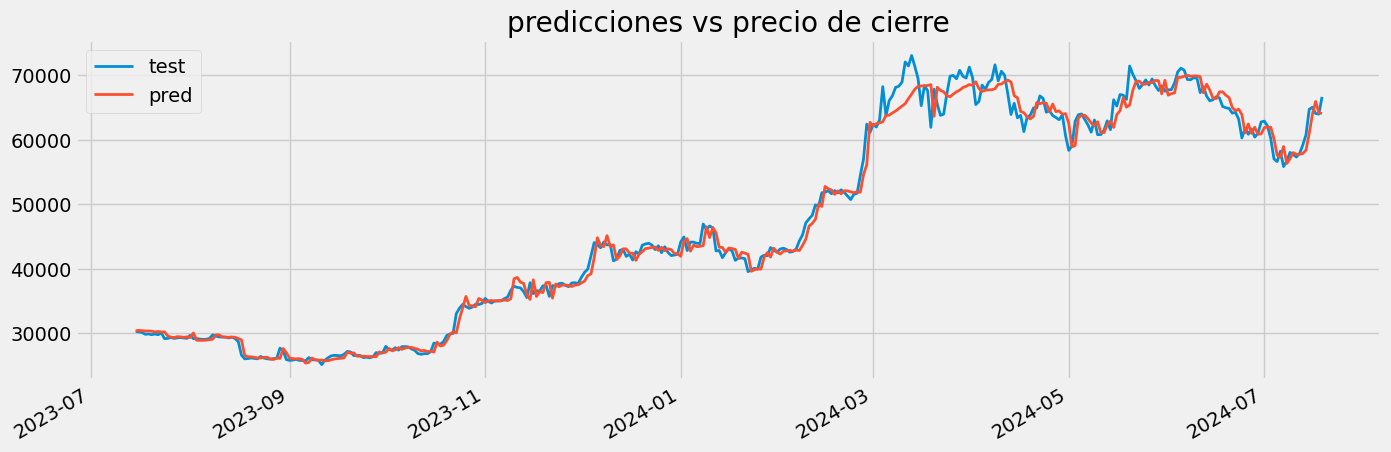

In [367]:
fig, ax = plt.subplots(figsize=(15,5))
data.loc[predicciones.index,'close'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2, label='Prediccion',ax=ax)
ax.set_title('predicciones vs precio de cierre')
ax.legend()


In [368]:
metrica

0.020862032578463172